TOC


0. [Slides](https://soph.info/slides/odsc2019.pdf)
1.   [Neural Net Theory](https://colab.research.google.com/gist/artificialsoph/1032e89227b1fe7707d6ea5e533e0b9c/01_nn_theory.ipynb)
2.   [Deep Convolutional GANs](https://colab.research.google.com/gist/artificialsoph/ade40c6da14505a8b56a5b4904d5d061/0-dc-gan.ipynb)
3.   [Advanced GANs](https://colab.research.google.com/gist/artificialsoph/968b60b40108f8516c3cc57e291ff9cb/1-advanced-gans.ipynb)
3.   [Multilable Conditional GANs](https://colab.research.google.com/gist/artificialsoph/14b5acca09b486fb693f83b5c09e916a/2-multilabel-conditional-gans.ipynb)



In [2]:
#######################
# standard code block #
#######################

# see https://ipython.readthedocs.io/en/stable/interactive/magics.html
%pylab inline

# sets backend to render higher res images
%config InlineBackend.figure_formats = ['retina']

#######################
#       imports       #
#######################
import pandas as pd
import seaborn as sns
import sklearn

!wget http://soph.info/metis/soph.py
from soph import plot_decision_boundary

sns.set_style("whitegrid")

Populating the interactive namespace from numpy and matplotlib
--2019-05-01 15:07:05--  http://soph.info/metis/soph.py
Resolving soph.info (soph.info)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to soph.info (soph.info)|185.199.108.153|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://soph.info/metis/soph.py [following]
--2019-05-01 15:07:05--  https://soph.info/metis/soph.py
Connecting to soph.info (soph.info)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13115 (13K) [application/octet-stream]
Saving to: ‘soph.py’

soph.py             100%[===================>]  12.81K  --.-KB/s    in 0s      

2019-05-01 15:07:05 (132 MB/s) - ‘soph.py’ saved [13115/13115]



Using TensorFlow backend.


# An Introduction to Neural Nets

### This notebook

In this notebook, we'll cover the two important "ingredients" of Neural Networks:
1. Layers
2. Activation functions

Note: We will use the keras library for demonstration, but it's not meant to be explained here.

## XOR

The XOR problem is a classic problem in machine learning. This problem asks a model to learn the XOR logical function reproduced below

X | Y | XOR
---|---|---
0 | 0 | 0
1 | 0 | 1
0 | 1 | 1
1 | 1 | 0

Question: Do you think this could be solved with logistic regression? Why or why not?

## Back up: revisit the problem of nonlinear data.

To get started discussing neural nets, we'll look at a very old question in Machine Learning: how do we get our models to learn nonlinear functions?

The data below is a cluster version of the XOR problem

Text(0.5, 1.0, 'Non-Separable clusters')

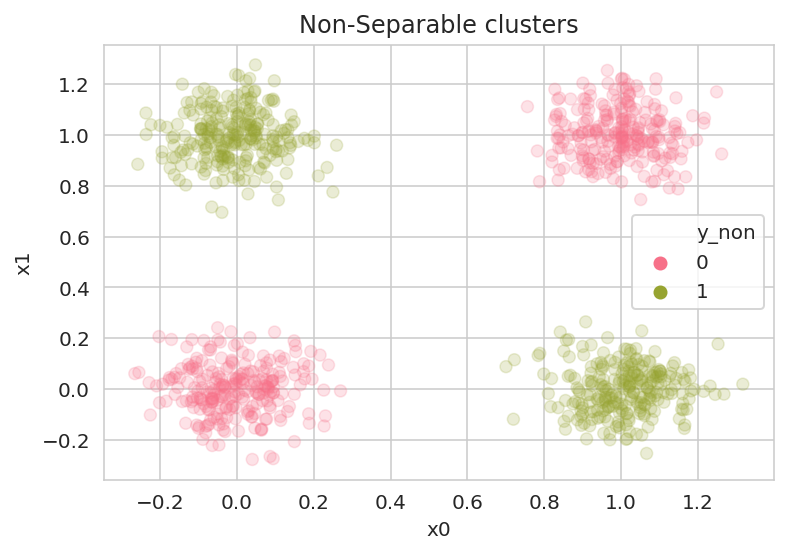

In [3]:
from sklearn import datasets

pal = dict(enumerate(sns.color_palette("husl", 4)))

x, y = datasets.make_blobs(n_samples=1000, n_features=2,
                           centers=[[0, 0], [0, 1], [1, 0],
                                    [1, 1]], cluster_std=.1, random_state=0)

blob_df = pd.DataFrame({"x0": x[:, 0], "x1": x[:, 1], "y": y})

blob_df["y_non"] = blob_df.y.isin([1, 2]).astype("int")

sns.scatterplot(x="x0", y="x1", hue="y_non", data=blob_df, alpha=.2,
                edgecolor=None, palette=pal)
title("Non-Separable clusters")

In [0]:
x.shape

(1000, 2)

## Building a model in keras


Let's learn how Keras works by building something we already know: Logistic Regression.

Recall that Logistic Regression uses the same linear operation we've become very familiar with:
$\hat{y} = \mathbf{w}^\top \mathbf{x} + b$

Logistic Regression uses the sigmoid function to transform the output of the above equation to a probability, $p(\hat{y} = 1 | \mathbf{x}) = \sigma( \mathbf{w}^\top \mathbf{x} + b)$. 

Below, we will use the building blocks provided by Keras to construct a Logistic Regression model.

Okay, let's talk about the code we'll use to build this model in keras:

The most common method we'll use to build models is `keras.Sequential`. Which works for any model where each layer flows directly into the next one.  
```python
svm_keras = keras.Sequential([...])
```

The input to `keras.Sequential` is a list of layers. More details on layers in the next cell.

In keras, models are built piece-by-piece using layers. Each layer performs one step of operations.

The operation we want to perform for Logistic Regression is $\mathbf{w}^\top \mathbf{x} + b$. That linear operation is performed by a dense layer: `keras.layers.Dense`.

```python
svm_keras = keras.Sequential([
    keras.layers.Dense(...),
])
```

When keras builds a model, it initializes all the necessary variables before running the model. In our case, these are $\mathbf{w}$ and $b$. In order to initialize these, keras must know their dimensionality (in other words, how big they are). 

Keras calculates the dimensionality from the size of the input and output. Take our example above: we have two input features, $x_1$ and $x_2$ and we want one output, $\hat{y}$. From that we can infer that we need $\mathbf{w}$ to have the shape $[2 \times 1]$ and $b$ to have the shape $[1]$. This is exactly how keras does it when we add our layer.

We'll add the `units=1` argument for the output size and the `input_shape=(2,)` for the input. 
```python
svm_keras = keras.Sequential([
    keras.layers.Dense(units=1, input_shape=(2, )),
])
```

The next step is to tell keras how to train the model using `svm_keras.compile(optimizer="sgd", loss="binary_crossentropy")`.

We'll use `optimizer="sgd"` to tell keras to use vanilla stochastic gradient descent when searching for the best $\mathbf{w}$ and $b$. 

The loss function measures how well we're doing. Binary Cross-Entropy is a loss function that works when we're predicting probabilities for a binary outcome. BCE reduces to zero when we predict 100% for every example labeled true and 0% for every example labeled false. BCE increases as we travel away from that ideal.

Finally, we'll train the model with 

```python
svm_keras.fit(x=blob_df[["x0", "x1"]], y=blob_df["y_non"], epochs=20)
```

The new term here is **epochs**. An epoch measures the number of times a model is shown the entire training dataset. So, `epochs=20` means that keras will go through 20 iterations of showing the model the data, optimizing the model, and repeating.

Now, we're ready to train the model! Let's back up and think again about the dataset that we're using. How do we expect a vanilla Logistic Regression model to do?

In [4]:
import keras

logreg_keras = keras.Sequential([
    keras.layers.Dense(units=1, input_shape=(2, )),
    keras.layers.Activation("sigmoid")
])

logreg_keras.compile(optimizer="sgd", loss="binary_crossentropy")

logreg_keras.fit(x=blob_df[["x0", "x1"]], y=blob_df["y_non"], epochs=20)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
1000/1000 [==============================] - 1s 644us/step - loss: 0.7436
Epoch 2/20
1000/1000 [==============================] - 0s 38us/step - loss: 0.7348
Epoch 3/20
1000/1000 [==============================] - 0s 36us/step - loss: 0.7280
Epoch 4/20
1000/1000 [==============================] - 0s 38us/step - loss: 0.7223
Epoch 5/20
1000/1000 [==============================] - 0s 39us/step - loss: 0.7175
Epoch 6/20
1000/1000 [==============================] - 0s 38us/step - loss: 0.7138
Epoch 7/20
1000/1000 [==============================] - 0s 40us/step - loss: 0.7107
Epoch 8/20
1000/1000 [==============================] - 0s 37us/step - loss: 0.7083
Epoch 9/20
1000/1000 [==============================] - 0s 38us/step - loss: 0.7064
Epoch 10/20
1000/1000 [==============================] - 0s 42us/step - loss: 0.7048
Epoch 11/20
1000/1000 [===============

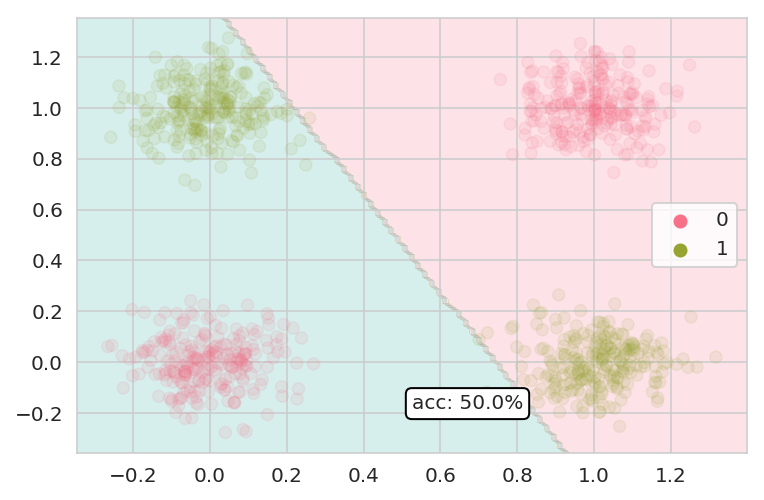

In [5]:
pred_func = lambda x: logreg_keras.predict(x) > .5

plot_decision_boundary(pred_func, x=blob_df[["x0", "x1"]].values,
                       y=blob_df["y_non"].values, points=1e4)

## Back to Square one

Okay, we're back to square one with using a linear classifier on nonlinear data. It doesn't work! 

**Recall**: How did we fix this for linear models previously?

Let's confirm that things like feature engineering still work

In [6]:
blob_df["x0*x1"] = blob_df["x0"]*blob_df["x1"]

logreg_keras = keras.Sequential([
    keras.layers.Dense(units=1, input_shape=(3, )),
    keras.layers.Activation("sigmoid")
])

logreg_keras.compile(optimizer="nadam", loss="binary_crossentropy")

logreg_keras.fit(x=blob_df[["x0", "x1", "x0*x1"]], y=blob_df["y_non"], epochs=100)

Epoch 1/100
1000/1000 [==============================] - 0s 223us/step - loss: 0.7829
Epoch 2/100
1000/1000 [==============================] - 0s 50us/step - loss: 0.7566
Epoch 3/100
1000/1000 [==============================] - 0s 44us/step - loss: 0.7322
Epoch 4/100
1000/1000 [==============================] - 0s 46us/step - loss: 0.7108
Epoch 5/100
1000/1000 [==============================] - 0s 47us/step - loss: 0.6919
Epoch 6/100
1000/1000 [==============================] - 0s 46us/step - loss: 0.6754
Epoch 7/100
1000/1000 [==============================] - 0s 40us/step - loss: 0.6606
Epoch 8/100
1000/1000 [==============================] - 0s 49us/step - loss: 0.6474
Epoch 9/100
1000/1000 [==============================] - 0s 46us/step - loss: 0.6352
Epoch 10/100
1000/1000 [==============================] - 0s 46us/step - loss: 0.6245
Epoch 11/100
1000/1000 [==============================] - 0s 42us/step - loss: 0.6148
Epoch 12/100
1000/1000 [==============================] - 0s 4

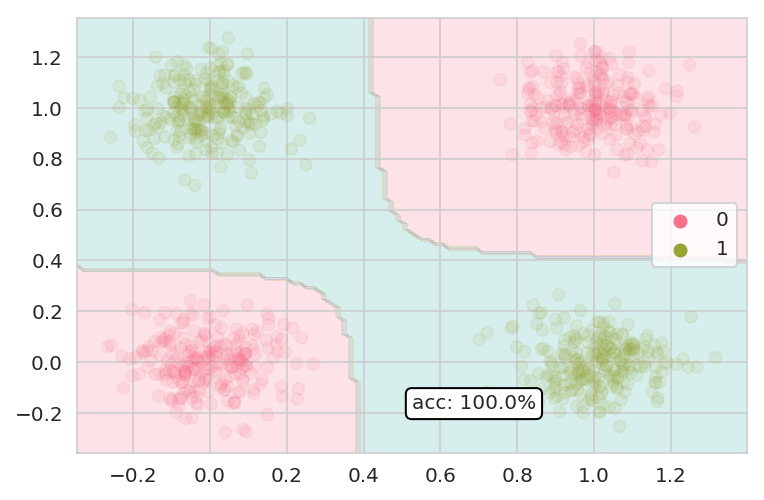

In [7]:
pred_func = lambda x: logreg_keras.predict(np.stack((x[:,0], x[:,1], x[:,0]*x[:,1]), axis=1)) > .5

plot_decision_boundary(pred_func, x=blob_df[["x0", "x1"]].values,
                       y=blob_df["y_non"].values, points=1e4)

Okay, so old tricks still work!

# The deep learning approach: aside

Okay, we can now use keras to build models that we've already learned. It's a bit tricker than just importing an off the shelf model from `sklearn` but we can do it. 

Now that we know the ropes a bit, we can start building actual *neural networks* and we can make comparisons between the traditional machine learning methods we've learned so far and deep learning.

**Traditional Machine Learning**: Relatively fixed models, focus on data pre-processing. Here we might take an off-the-shelf model and then prepare the data for the model using kernels, feature extraction and engineering, and hand prep of data. With a few exceptions, the success or failure of your model will be strongly impacted by the details of your data preparation.

**Deep Learning**: Minimal data pre-processing, focus on model building. Here, we might perform some minimal data pre-processing step and then consider the data fixed. Most of our work will be setting up the model so that it *is able to* learn it's own transformation steps. 

In general, the deep learning approach leads to a lot more tinkering *with the structure of the model* and a lot less tinkering with your data. The power of this approach is that the processing steps are learned by the model based on the training data and and task. In many cases, this learned processing pipeline can outperform anything humans have been able to come up with by hand.

## The deep learning approach: what's the catch?

This little statement "setting up the model so that it *is able to* learn it's own transformation steps" is often easier said than done. 

In fact, in a typical deep learning project, much of the work is in finding the best architectures and modifications. 

# The deep learning approach: back to code

Here you'll learn about two of the essential ingredients to any deep learning model:
1. Layers
2. Activations

# Ingredient 1: Layers

The first ingredient is *layers*. An insight of neural nets is that we can use the linear function several times in a sequence. In this case, every application of our linear function is called a "layer". Below we have $n$ layers and at the very end, we'll use $\hat{\mathbf{y}} = \mathbf{h}_n$ as our estimate of our outputs:

$$\mathbf{h}_1 = \mathbf{w}_1^\top \mathbf{x} + b_1$$
$$\mathbf{h}_2 = \mathbf{w}_2^\top \mathbf{h}_1 + b_2$$
$$\dots$$
$$\mathbf{h}_n = \mathbf{w}_n^\top \mathbf{h}_{n-1} + b_n$$

Now, $\mathbf{h}_1$ is a <u>**hidden layer**</u>—a layer whose output is not used directly for prediction. 

## Why layers?

Using several layers allows the model to learn how to transform and extract valuable information from the input data and then to use that newly transformed and extracted information to perform some task, like classification or regression.  

Before Deep Learning, these are steps that were typically performed ahead of time, or using kernels. 

Okay, let's revisit that non-separable blob dataset but this time, we'll see how this would be solved with deep learning.

Text(0.5, 1.0, 'Non-Separable clusters')

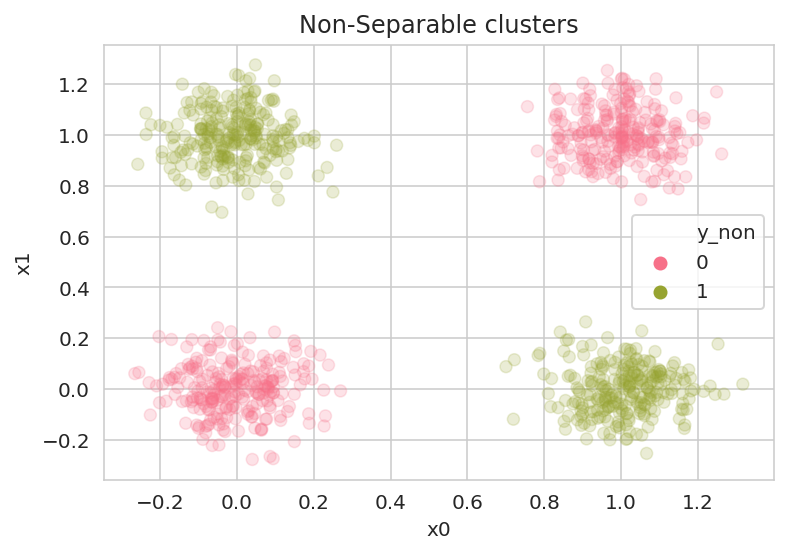

In [8]:
sns.scatterplot(x="x0", y="x1", hue="y_non", data=blob_df, alpha=.2,
                edgecolor=None, palette=pal)
title("Non-Separable clusters")

In the code below, we're adding a second layer with 10 units. This is a relatively shallow network described by the following equation

$$\mathbf{h}_1 = \mathbf{w}_1^\top \mathbf{x} + b_1$$
$$\hat{\mathbf{y}} = \mathbf{w}_2^\top \mathbf{h}_1 + b_2$$.


In [9]:
deep_model = keras.Sequential([
    keras.layers.Dense(units=10, input_shape=(2, )),
    keras.layers.Dense(units=1),
    keras.layers.Activation("sigmoid")
])

deep_model.compile(optimizer="sgd", loss="binary_crossentropy")

deep_model.fit(x=blob_df[["x0", "x1"]], y=blob_df["y_non"], epochs=20)

Epoch 1/20
1000/1000 [==============================] - 0s 242us/step - loss: 0.7050
Epoch 2/20
1000/1000 [==============================] - 0s 38us/step - loss: 0.7039
Epoch 3/20
1000/1000 [==============================] - 0s 37us/step - loss: 0.7029
Epoch 4/20
1000/1000 [==============================] - 0s 39us/step - loss: 0.7021
Epoch 5/20
1000/1000 [==============================] - 0s 37us/step - loss: 0.7013
Epoch 6/20
1000/1000 [==============================] - 0s 56us/step - loss: 0.7004
Epoch 7/20
1000/1000 [==============================] - 0s 39us/step - loss: 0.6998
Epoch 8/20
1000/1000 [==============================] - 0s 40us/step - loss: 0.6992
Epoch 9/20
1000/1000 [==============================] - 0s 36us/step - loss: 0.6988
Epoch 10/20
1000/1000 [==============================] - 0s 38us/step - loss: 0.6984
Epoch 11/20
1000/1000 [==============================] - 0s 39us/step - loss: 0.6980
Epoch 12/20
1000/1000 [==============================] - 0s 37us/step - l

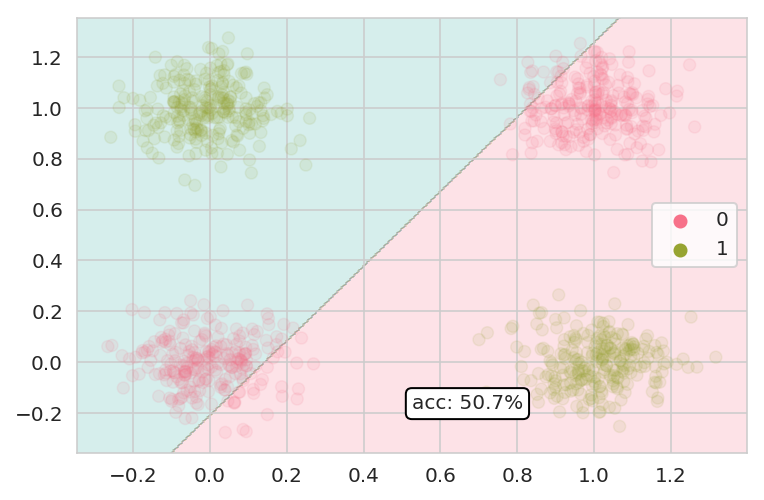

In [10]:
pred_func = lambda x: deep_model.predict(x) > .5

plot_decision_boundary(pred_func, x=blob_df[["x0", "x1"]].values,
                       y=blob_df["y_non"].values, points=1e5)

As you can clearly see, layers alone are not enough.

## Ingredient 2: a nonlinear activation function

Can you spot the problem with the previous model?

When linear functions are combined, the result is still limited to being a linear function. 

In other words, combining layers of linear functions will never allow our model to learn something nonlinear.

We can fix this with a nonlinear activation function $f_a$.

$$\mathbf{h}_1 = f_a(\mathbf{w}_1^\top \mathbf{x} + b_1)$$
$$\hat{\mathbf{y}} = \mathbf{w}_2^\top \mathbf{h}_1 + b_2$$

![](img/relu.svg)

Specifically, we'll use the relu activation function $f_a(\mathbf{x}) = \max(\mathbf{x},0) $

The addition of a nonlinear activation function allows the model to learn to process input in a nonlinear fashion, which is essential for classifying datasets like our blob dataset. 

In [11]:
deep_model = keras.Sequential([
    keras.layers.Dense(units=10, input_shape=(2, ), name="hidden_layer"),
    keras.layers.Activation("relu", name="hidden_activation"),
    keras.layers.Dense(units=1, name="output_layer"),
    keras.layers.Activation("sigmoid", name="sigmoid_activation"),
])

deep_model.compile(optimizer="nadam", loss="binary_crossentropy", metrics=["acc"])

deep_model.fit(x=blob_df[["x0", "x1"]], y=blob_df["y_non"], epochs=20)

Epoch 1/20
1000/1000 [==============================] - 0s 364us/step - loss: 0.7344 - acc: 0.4350
Epoch 2/20
1000/1000 [==============================] - 0s 41us/step - loss: 0.6952 - acc: 0.4790
Epoch 3/20
1000/1000 [==============================] - 0s 36us/step - loss: 0.6515 - acc: 0.6640
Epoch 4/20
1000/1000 [==============================] - 0s 41us/step - loss: 0.6042 - acc: 0.7500
Epoch 5/20
1000/1000 [==============================] - 0s 39us/step - loss: 0.5566 - acc: 0.7500
Epoch 6/20
1000/1000 [==============================] - 0s 36us/step - loss: 0.5109 - acc: 0.8050
Epoch 7/20
1000/1000 [==============================] - 0s 49us/step - loss: 0.4676 - acc: 0.9380
Epoch 8/20
1000/1000 [==============================] - 0s 37us/step - loss: 0.4268 - acc: 0.9640
Epoch 9/20
1000/1000 [==============================] - 0s 41us/step - loss: 0.3883 - acc: 0.9780
Epoch 10/20
1000/1000 [==============================] - 0s 43us/step - loss: 0.3521 - acc: 0.9860
Epoch 11/20
1000/1

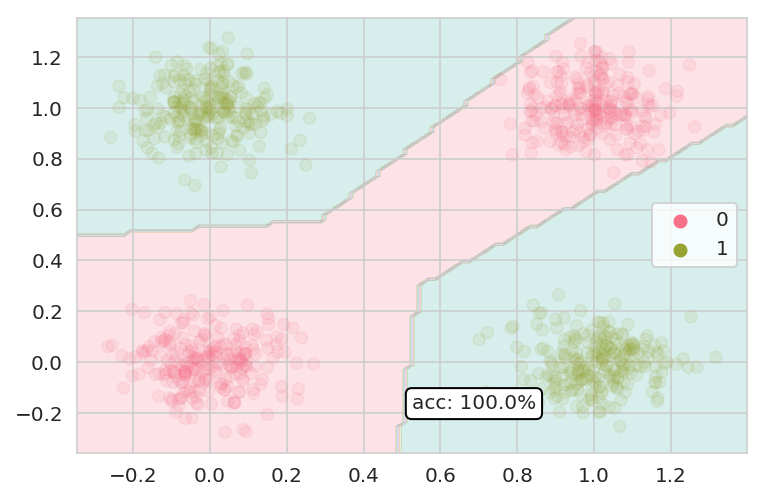

In [12]:
pred_func = lambda x: deep_model.predict(x) > .5

plot_decision_boundary(pred_func, x=blob_df[["x0", "x1"]].values,
                       y=blob_df["y_non"].values, points=1e4)

In [14]:
[arr.shape for arr in deep_model.get_layer("hidden_layer").get_weights()]

[(2, 10), (10,)]

We did it!

How'd we do it? Let's look at a few test points to see. 

In [15]:
deep_model.save("img/deep_model.h5")

OSError: ignored

**INSTRUCTION NOTE**
The code to make the following plot is stored in [`utils/relu_plot.ipynb`](utils/relu_plot.ipynb). It is beyond the scope of this lesson but students are encouraged to refer back to it for examples of how to:
- annotate plots
- extract outputs at different layers of a neural network

![](img/activation_function_demo.svg)

Let's look closely at how our neural net accomplishes the task. 

- The first linear operation may not seem like much, but our model has learned a clever trick: It squishes all of the points onto a single line. Points that have similar values on each dimension (like $[1,1]$ and $[0,0]$) are pushed to the center of the line while points with lopsided values (like $[1,0]$, and $[0,1]$ are pushed to either end.
- Normally, this alone would be no help. We still can't separate these points with a linear classifier. **However**, this is where our function relu comes in. (recall $\text{relu}(x) = \max(x,0)$)
- The relu activation function pushes one leg of this line up while leaving the rest in place. A linear function wouldn't be able to select part of the line to move, but relu can!
- Now the next layer is set up for an easy classification problem. Voila!

# Takeaways

The most important points:
- At the core of Neural Networks is our friend, the linear operation: $\mathbf{w}^\top\mathbf{x} + b$
- Two essential ingredients of Neural Nets:
    - multiple layers
    - nonlinear activation functions
- Neural Nets replace hand selected pre-processing steps with transformations learned from the data

# Activation functions for hidden  layers



| Activation function | Function | Plot | Notes | 
|:--------------------|:------|:------|:-----|
| ReLU (Rectified Linear Unit) | $$f(x) = \max(x, o)$$ | ![](img/relu.svg) | General purpose. Great default. |
| tanh | $$f(x) = \tanh(x)$$ | ![](img/tanh.svg) |  |
| LeakyReLU | $$f(x) = \begin{cases} \alpha x & x < 0 \\ x & x \geq 0 \end{cases} $$ | ![](img/Leakyrelu.svg) | Useful in Generative Adversarial Networks. Cases where gradient needs to flow even in off state. |
| ELU (Exponential Linear Unit) | $$f(x) = \begin{cases} \alpha e^{(x-1)} & x < 0 \\ x & x \geq 0 \end{cases} $$ |  ![](img/elu.svg) | Sometimes better for image recognition. |



# Activation functions for Output layers

| Activation function | Function | Plot | Notes | 
|---------------------|-------|-------|------|
| Linear | $f(x) = x $ | ![](img/linear.svg) | Regression |
| Sigmoid | $$f(x) = \sigma(x) = \frac{1}{1+e^{-x}}$$ | ![](img/sigmoid.svg) | Binary (two class) classification |
| SoftMax | $$f_i(\mathbf{x}) = \frac{e^{x_i}}{ \sum_{x_j \in \mathbf{x}} e^{x_j}} $$ | - | Multi-class classification | 